Importieren der notwendigen Bibliotheken

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, classification_report, confusion_matrix, precision_score, \
    recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import os
import joblib

Einlesen der Daten

In [26]:
# read encoded data
df = pd.read_csv('data/churn_data_encoded.csv')


Definieren der benutzerdefinierten Bewertungsfunktion und Hilfsfunktionen

In [37]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer

# Define own scoring function based on estimated FP and FN costs
def custom_score(y_true, y_pred):
    # Define scores: FP = 1, FN = 5, TP = TN = 0
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    total = len(y_true)
    score = (fp + 5 * fn) / total # set score in relation to total number of samples
    return score

def print_scores(scores):
    # Print scores for each fold
    scores_df = pd.DataFrame({
        'Fold': np.arange(1, len(scores['test_accuracy']) + 1),
        'Accuracy': scores['test_accuracy'],
        'Precision': scores['test_precision'],
        'Recall': scores['test_recall'],
        'F1': scores['test_f1'],
        'Custom Score': scores['test_custom_score'],
        })
    print("Scores:\n", scores_df)

    # Print average scores
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'custom_score']
    statistics = pd.DataFrame(index=metrics, columns=['Min', 'Mean', 'Max'])

    for metric in metrics:
        statistics.loc[metric, 'Min'] = scores['test_' + metric].min()
        statistics.loc[metric, 'Mean'] = scores['test_' + metric].mean()
        statistics.loc[metric, 'Max'] = scores['test_' + metric].max()
    print("\nStatistics:\n", statistics)

# cross validation
def evaluate_classification(X, y, classifier):
    # Create custom scorer
    custom_scorer = make_scorer(custom_score, greater_is_better=False)

    # Use cross-validation to evaluate performance
    cv = StratifiedKFold(
        shuffle=True,
        n_splits=10,
        random_state=42
        )

    scores = cross_validate(
        classifier,
        X,
        y,
        cv=cv, scoring={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1',
        'custom_score': custom_scorer,
        })

    print_scores(scores)
    return scores

Datenvorbereitung und -skalierung

In [28]:
# bilde Funktion mit unabhängigen Variablen und abhängiger Variable Churn
X = df.drop('Churn', axis=1)
y = df['Churn']

# Balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check if classes are balanced
print(y_resampled.value_counts())

Churn
0    5174
1    5174
Name: count, dtype: int64


Skalierung

In [29]:
# Scale features
scaler = MinMaxScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

Modelltraining mit cross evaluation

In [38]:
clf = LogisticRegression(
    max_iter=2000,
    solver='lbfgs',
    random_state=42
)
#cross evaluation split
scores = evaluate_classification(X_resampled_scaled,
                                 y_resampled, clf)

Scores:
    Fold  Accuracy  Precision    Recall        F1  Custom Score
0     1  0.973913   0.978516  0.969052  0.973761     -0.087923
1     2  0.979710   0.984375  0.974855  0.979592     -0.070531
2     3  0.979710   0.976923  0.982592  0.979749     -0.055072
3     4  0.966184   0.972549  0.959381  0.965920     -0.114976
4     5  0.980676   0.992095  0.969112  0.980469     -0.081159
5     6  0.976812   0.980545  0.972973  0.976744     -0.077295
6     7  0.971014   0.976562  0.965251  0.970874     -0.098551
7     8  0.971014   0.980315  0.961390  0.970760     -0.106280
8     9  0.979691   0.984375  0.974855  0.979592     -0.070600
9    10  0.970019   0.970930  0.969052  0.969990     -0.091876

Statistics:
                    Min      Mean       Max
accuracy      0.966184  0.974874  0.980676
precision      0.97093  0.979719  0.992095
recall        0.959381  0.969851  0.982592
f1             0.96592  0.974745  0.980469
custom_score -0.114976 -0.085426 -0.055072


Modelltraining und Evaluierung

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0. 3, random_state=42)

clf = LogisticRegression(
    max_iter=2000,
    solver='lbfgs',
    random_state=42
)

clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)

y_pred_test = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f'Train Accuracy: {train_accuracy}')
print(f'Test Accuracy: {test_accuracy}')


Train Accuracy: 0.9831561507662571
Test Accuracy: 0.975523349436393


Hyperparameter-Optimierung mit GridSearchCV

In [42]:
# Hyperparameter-Optimierung mit GridSearchCV
def apply_grid_search(classifier, param_grid, X, y, cv=5, scoring='accuracy'):
    grid_search = GridSearchCV(classifier, param_grid, cv=cv, scoring=scoring)
    grid_search.fit(X, y)
    print("Best hyperparameters:")
    print(grid_search.best_params_)
    return grid_search.best_estimator_

# test no of iterations, solver & regulation coefficient
param_grid = {
    'max_iter': [5000, 10000],
    'solver': ['lbfgs', 'liblinear'],
    'C': [0.1, 1, 10]
}

best_model = apply_grid_search(LogisticRegression(random_state=42), param_grid, X_train,
                               y_train, cv=5, scoring='accuracy')



Best hyperparameters:
{'C': 1, 'max_iter': 5000, 'solver': 'lbfgs'}


Endgültiges Modelltraining und Evaluierung

In [56]:
# Endgültiges Modelltraining und Evaluierung
best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)

y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("Training classification report:")
print(classification_report(y_test, y_test_pred))


Training classification report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1574
           1       0.98      0.97      0.97      1531

    accuracy                           0.98      3105
   macro avg       0.98      0.98      0.98      3105
weighted avg       0.98      0.98      0.98      3105



In [58]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
print(conf_matrix)

conf_matrix_rel = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
print(conf_matrix_rel)

[[1548   26]
 [  50 1481]]
[[0.98348158 0.01651842]
 [0.03265839 0.96734161]]


In [59]:
# Calculate Cost
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
cost = fp + 5 * fn
print("Cost: ", cost)

Cost:  276


In [47]:
# Save model
os.makedirs('models', exist_ok=True)
joblib.dump(best_model, 'models/logistic_regression_model.pkl')

['models/logistic_regression_model.pkl']

Modell testen

Konfusionsmatrix

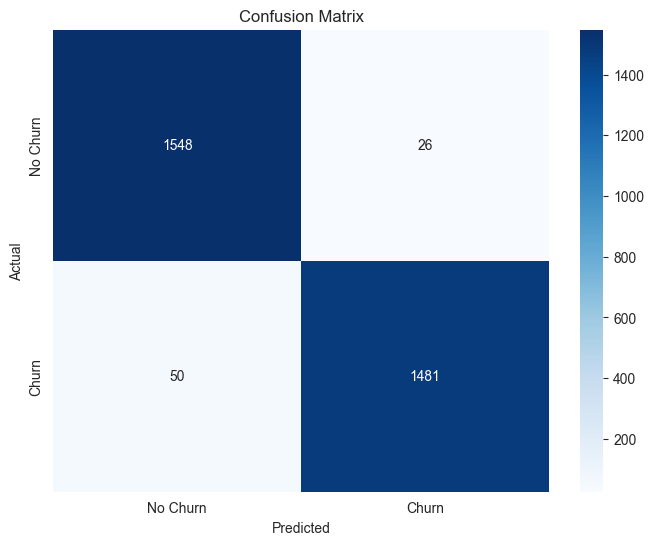

In [60]:
# Plotting Konfusionsmatrix für Testdaten
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Vorhersagewahrscheinlichkeiten

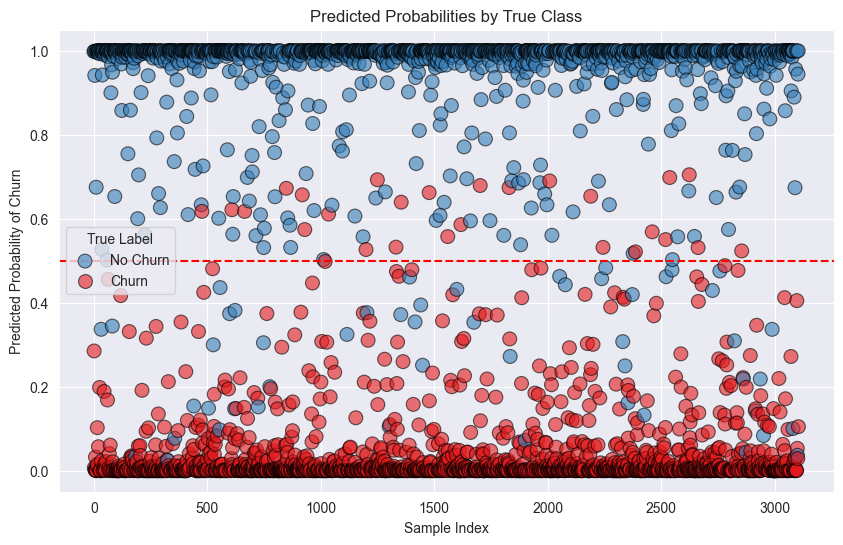

In [61]:
# Plotting der vorhergesagten Wahrscheinlichkeiten für Testdaten
results = pd.DataFrame({
    'True Label': y_test,
    'Predicted Probability': y_test_pred_proba
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=np.arange(len(results)), y='Predicted Probability', hue='True Label', data=results, palette='Set1', s=100, alpha=0.6, edgecolor='k')
plt.axhline(0.5, ls='--', color='red')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Probability of Churn')
plt.title('Predicted Probabilities by True Class')
plt.legend(title='True Label', labels=['No Churn', 'Churn'])
plt.grid(True)
plt.show()

Featureanalyse

In [66]:
coefficients = clf.coef_[0]

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients,
    'Absolute Coefficient': np.abs(coefficients)
})

feature_importance = feature_importance.sort_values(by='Absolute Coefficient', ascending=False)
feature_importance.head()

,Feature,Coefficient,Absolute Coefficient
34,Satisfaction Score,-13.198120,13.198120
12,Number of Referrals,-3.586308,3.586308
1149,Contract_Month-to-Month,2.090950,2.090950
19,Online Security,-2.041123,2.041123
28,Monthly Charge,1.737482,1.737482
